<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/modelo_monod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Modelo  de Monod reactor continuo 

Autor: Juan Manuel Gutiérrez García

Afiliación: Instituto Tecnológico de Morelia 

Fecha: Enero 2021

# Resumen 

En el presente libro analizamos un biorreactor continuo haciendo uso del modelo de Monod. Empezamos por realizar un análisis de estabilidad donde encontramos los puntos críticos, el diagrama de plano de fase y el diagrama de bifurcación. Continuamos con el análsis dinámico del modelo, i.e., simulación mediante integración numérica. Hacemos uso de datos experimentales y algoritmos genéticos para obtener los parámetros cinéticos y generar conclusiones sobre el comportamiento del proceso. Finalmente realizamos una optimización para determinar el valor de la tasa de dilución, $D$, que permite obtener la máxima cantidad de biomasa en condiciones estacionarias 

# Descripción del proceso

En un biorreactor continuo consideramos un flujo de entrada, $F_{in}$, y un flujo de salida, $F$, del biorreactor. Para mantener un volumen constante se debe cumplir que el flujo de alimentación y de salida sean iguales. Se consideran tres especies, la biomasa, $x$, el producto, $p$, y el sustrato, $s$. Además, suponemos que el flujo de alimentación solo contiene sustrato, $s_f$. 


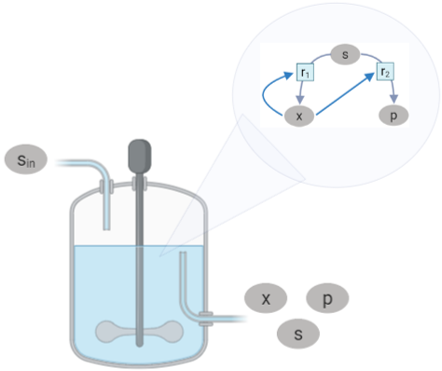

Figura 1. Esquema de un biorreactor continuo en que el ocurren reacciones de transformación de sustrato en biomasa y producto 

# Suposiciones

* La densidad es constante en todo el biorreactor

* La concentración de las especies es homogénea en todo el biorreactor

* Los parámetros cinéticos permanecen constantes durante la fermentación (esta es una suposición factible siempre y cuando la temperatura no cambie mucho)

* Solo existe un tipo de sustrato en el biorreactor del cual las células se pueden alimentar

* Solo existe un tipo de microorganismo en el biorreactor

# Modelado de ecuaciones

El modelo dinámico se desarrolla escribiendo balances de materia total, para la biomasa (células), el sustrato (fuente de alimentación para las células) y el producto (metabolito generado). La biomasa crece alimentándose del sustrato.



### Balance de materia total 

$$acumulación\ de\ materia\ =\ entrada\ por\ flujo\ -\ salida\ por\ flujo$$

$$\frac{d(\rho V)}{dt} = F_{in} \rho - F_{out} \rho$$

Considerando que la densidad, $\rho$, es constante y que en un reactor continuo $F_{int} = F_{out} = F$

$$\frac{dV}{dt} = 0$$

En un reactor continuo el volumen permanece constante 

### Balance de materia para la biomasa

Ya que supusimos que no hay biomasa en el flujo de alimentación se tiene 

$$acumulación\ de\ biomasa\ =\ generación\ -\ salida\ por\ flujo$$


$$\frac{d(xV)}{dt} = r_x V - F x$$

Considerando que el volumen es constante y que la tasa de dilución se define como 

$$D = \frac{F}{V}$$

la cual es el inverso del tiempo de residencia y tiene unidades de $timepo^{-1}$

Se tiene que 

<a id = 'equatio-la-se2'></a>
$$
\frac{dx}{dt} = r_x - D x \tag{1}
$$

### Balance de materia para el sustrato 

$$acumulación\ de\ materia\ =\ entrada\ por\ flujo -\ salida\ por\ flujo -\ consumo$$ 

$$\frac{d(sV)}{dt} = F s_f - F s - r_s V$$ 

<a id = 'equation-la-se2'></a>
$$
\frac{ds}{dt} = D (s_f - s) - r_s \tag{2}
$$

### Balance de materia para el producto 

Al igual que la biomasa, no se encuentra producto presente en el flujo de alimentación

$$acumulación\ de\ producto\ =\ generación\ -\ salida\ por\ flujo$$

$$\frac{d(pV)}{dt} = r_p V - F p$$

<a id = 'equation-la-se2'></a>
$$
\frac{dp}{dt} = r_p  - D p \tag{3}
$$



## Tasa de crecimiento modelo de Monod

La velocidad de crecimiento de biomasa, $r_x$, se expresa comunmente como 

$$r_x = \mu(s) x$$

Donde $\mu(s)$ suele ser una función del sustrato. Existen diversas expresiones para representar esta función. Algunas de ellas consideran efectos de inhibición por sustrato o por producto. Para nuestro análisis consideramos el modelo de Monod

<a id = 'equation-la-se2'></a>
$$
\mu(s) =  \mu_{max} \left( \frac{s}{k_s + s}  \right) \tag{4}
 $$

Donde $\mu_{max}$ es la tasa máxima de crecimiento y $k_s$ represente la concentración de sustrato a la cual se alcanza la mitad de la tasa máxima de crecimiento.

### Inhibición por sustrato

A veces, la tasa de crecimiento aumenta con una concentración de sustrato baja, pero disminuye con una concentración de sustrato alta. Este efecto se llama inhibición por sustrato y está representado por la siguiente ecuación:

<a id = 'equation-la-se2'></a>
$$
\mu = \mu_{max} \left( \frac{s}{k_s + s + k_i s^{2}} \right) \tag{5}
$$

El modelo de Monod es una caso especial de (5) cuando $k_i = 0$ 

## Rendimientos

Para relacionar la velocidad de crecimiento de biomasa, $r_x$, con las velocidades de consumo de sustrato, $r_s$, y generación de producto, $r_p$, se emplean los rendimientos biomasa-sustrato y producto-biomasa, respectivamente. Estos rendimientos se definen como

Rendimiento biomasa-sustrato

$$Y_{xs} = \frac{r_x}{r_s}$$
Rendimiento producto-biomasa

$$Y_{px} = \frac{r_p}{r_x}$$
Donde $Y_{xs}$ y $Y_{px}$ son constantes.

Considerando lo anterior podemos reescribir las ecuaciones (1)-(3) como 

$$
\begin{aligned}

\frac{dx}{dt} &= r_x - Dx \\

\frac{ds}{dt} &= D(s_f - s) - \frac{1}{Y_{xs}} r_x \\

\frac{dp}{dt} &= Y_{px} r_x - D p

\end{aligned}
$$

Siendo 

$$r_x = \mu_{max}  \left( \frac{s}{k_s + s} \right)x $$

In [2]:
# cargar librerias 
install.packages("deSolve")
library(deSolve)
install.packages("ggplot2")
library(ggplot2)
install.packages("xlsx")
library(xlsx)
install.packages("GA")
library(GA)
# cargar Grind.R
install.packages("rootSolve")
install.packages("FME")
source("Grind.R")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rJava’, ‘xlsxjars’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’, ‘RcppArmadillo’


Loading required package: foreach

Loading required package: iterators

Package 'GA' version 3.2
Type 'citation("GA")' for citing this R package in publications.


Attaching package: ‘GA’


The following object is masked from ‘package:utils’:

    de


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘coda’, ‘minpack.lm’, ‘minqa’


Loading required package: coda



grind.R was sourced


# Comparción entre modelo de Monod y modelo de inhibición por sustrato

In [69]:
# modelo de monod 
monod <- function(s) {

  mu = mu_max*s/(ks + s)

  return(mu)
}

In [70]:
# modelo de inhibición por sustrato
subinhib <- function(s) {

  mu = mu_max*s/(ks + s + ki*s^2)

  return(mu)
}

In [71]:
# establecer parámetros para la comparación

# Monod
mu_max <- 0.53 # hr^-1
ks <- 0.12 # g/L

# inhibición
mu_max <- 0.53 # h^-1
ks <- 0.12 # g/L
ki <- 0.4545 # g/L

In [72]:
# simular modelos
s <- seq(0,5,len=100)
mu_mod <- monod(s)
mu_inh <- subinhib(s)
data <- data.frame(s = s, monod = mu_mod, inhibition = mu_inh)

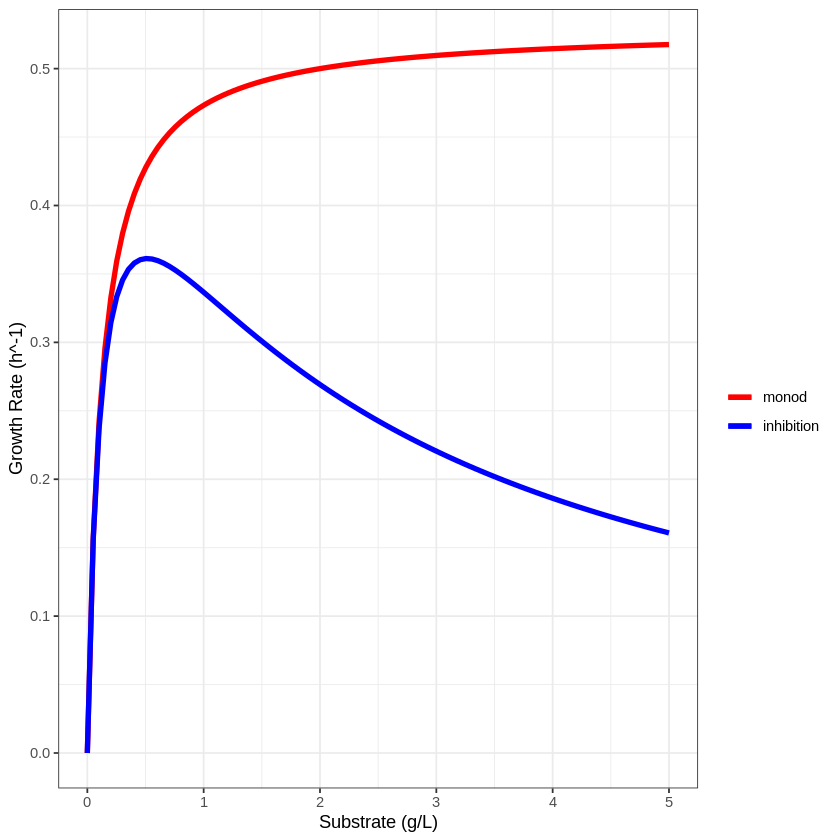

In [73]:
# mostrar comparación
ggplot(data,aes(s)) +
  geom_line(aes(y=monod, color = "monod"), lwd = 1.5) +
  geom_line(aes(y=inhibition, color = "inhibition"), lwd = 1.5) +
  scale_color_manual("", breaks = c("monod", "inhibition"),
                          values = c("red","blue")) +
  xlab("Substrate (g/L)") +
  ylab("Growth Rate (h^-1)") +
  theme_bw()

Figura 2. Comparación de modelo de Monod y modelo de inhibición por producto 

En la Fig.2 se observa como mientras el modelo de Monod decribe un incremento monótono de la tasa de crecimiento de biomasa el modelo de inhibición por sustrato muestra un pico y después una disminución. La decisión de qué modelo usar dependerá de las condiciones bajo las que se realiza la fermentación 

# Red para describir el proceso 

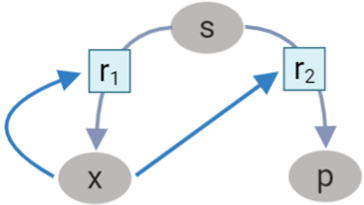

Figura 3. Red del proceso donde se observan las "reacciones" así como las especies que intervienen en estas reacciones y su efecto sobre las reacciones 

En la Fig.3 se observa que para describir el presente proceso se consideran solamente dos reacciones, la reacción $r_1$ da lugar a la generación de biomasa, $x$, a partir del sustrato, $s$, mientras que la reacción $r_2$ da lugar a la generación de producto, $p$, a partir de sustrato. También se observa que la biomasa tiene un efecto positivo sobre ambas reacciones. 

# Análisis de estabilidad  modelo de Monod


En las siguientes secciones se describen con detalle los puntos de equilibrio así como su dependencia con respecto a los parámetros del modelo. Aquí se muestran los dos puntos de equilibrio que se encontraron:

<a id = 'equation-la-se2'></a>
$$
\frac{ds}{dt} = 0 \hspace{1cm}  \rightarrow \hspace{1cm} D(s_{f} - \bar{s}) - r_{s} = 0 \tag{6}  
$$

<a id = 'equation-la-se2'></a>
$$
\frac{dx}{dt} = 0 \hspace{1cm}  \rightarrow \hspace{1cm}  r_{x} - D \bar{x} = 0 \tag{7}
$$

<a id = 'equation-la-se2'></a>
$$
\frac{dp}{dt} = 0 \hspace{1cm}  \rightarrow \hspace{1cm}  r_{p} - D \bar{p} = 0 \tag{8}
$$

Resolviendo la ecuaciones (1)-(3) para las variables $s$, $x$ y $p$ se obtienes los siguientes puntos de equilibrio:



$$ss_1: \hspace{1cm} \bar{s} = s_{f}, \hspace{0.25cm} \bar{x} = 0, \hspace{0.25cm} \bar{p} = 0$$ \

$$ss_2: \hspace{1cm} \bar{s} = \frac{Dk_s}{\mu_{max} - D}, \hspace{0.25cm} \bar{x} = Y_{xs} (s_f - \bar{s}), \hspace{0.25cm} \bar{p} = Y_{px} \bar{x}$$

El primer punto de equilibrio, $ss_1$, se considera un punto de equilibrio trivial, en el cual no existe biomasa presente en el birreactor y la concentración de sustrato es igual a la concentración de sustrato en la alimentación. Como veremos más adelante, este punto de equilibrio es inestable a valores bajos de la tasa de dilución, $D$, y estable a valores altos. El segundo punto de equilibrio, $ss_2$, es estable a valores bajos de la tasa de dilución e inestable a valores altos.

Puntos de equilibrio obtenidos con Python.

https://github.com/JuanM-GG/Biologia-de-sistemas/blob/main/puntos_de_equilibrio.ipynb

Como es posible observar del modelo matemático, las ecuaciones de sustrato y biomasa están desacopladas de la ecuación del producto, más aún, el punto de equilibrio del producto es solo un múltiplo del punto de equilibrio de la biomasa. Por lo anterior, en lo siguiente consideramos solamente las ecuaciones para la biomasa y el sustrato 

Empezamos por estudiar un proceso con los siguientes parámetros 

Tabla 1. Valor de parámetros considerados durante el análisis 

|parámetros cinético | parámetro de operación | 
|:---:|:---:|
| $\mu_{max} = 1.2\ h^{-1}$ | $s_f = 10\ g/L$|
| $k_{s} = 180\ g/L$ | $D = 0.01 h^{-1}$|
| $Y_{xs} = 0.1 $ | |

In [3]:
model <- function(times, state, parms) {
  with(as.list(c(state, parms)), {

    # velocidad de crecimiento (Monod)
    rx = mu_max*s/(ks + s)*x

    # velocidad de consumo de sustrato
    rs = (1/Yxs)*rx

    # balance de materia para el sustrato
    dsdt = D*(sf - s) - rs

    # balance de materia para la biomasa
    dxdt = rx - D*x

    return(list(c(dsdt,dxdt))) 
  })
}

In [4]:
# establecer parámetros 
p <- c(mu_max = 1.2, ks = 180, Yxs = 0.1, D = 0.01, sf = 10)

In [5]:
# condiciones iniciales
s <- c(s = 10, x = 0.1)

Para nuestro análisis es conveniente crear una función que nos permita encontrar el valor de los puntos de equilibrio dado un vector de parámetros. Nos servirá para comprobar los resultados que obtengamos más adelante

In [6]:
# función para calcular los puntos de equilibrio
steady_state <- function(p) {
  with(as.list(p), {

    # primer punto de equilibrio
    s = sf
    x = 0
    ss1 = c(s = s, x = x)

    # segundo punto de equilibrio
    s = D*ks/(mu_max - D)
    x = Yxs*(sf-s)
    ss2 = c(s = s, x = x)

  return(list(ss1 = round(ss1, 3),ss2 = round(ss2, 3)))
  })
}

¿Cuáles son los puntos de equilibrio para el valor de los parámetros que hemos establecido?

In [7]:
steady_state(p)

$ss1
 s  x 
10  0 

$ss2
    s     x 
1.513 0.849

Para ver los puntos de equilibrio en un plano de fase, junto con las ceroclinas, usamos la función `plane()` y la función `newton()`

s         x 
1.6352542 0.8732625

 s  x 
10  0 
Unstable point, eigenvalues:  0.05315789 -0.01 


s  x 
10  0

        s         x 
1.5125855 0.8487414 
Stable point, eigenvalues:  -0.05564379 -0.01 


s         x 
1.5125855 0.8487414

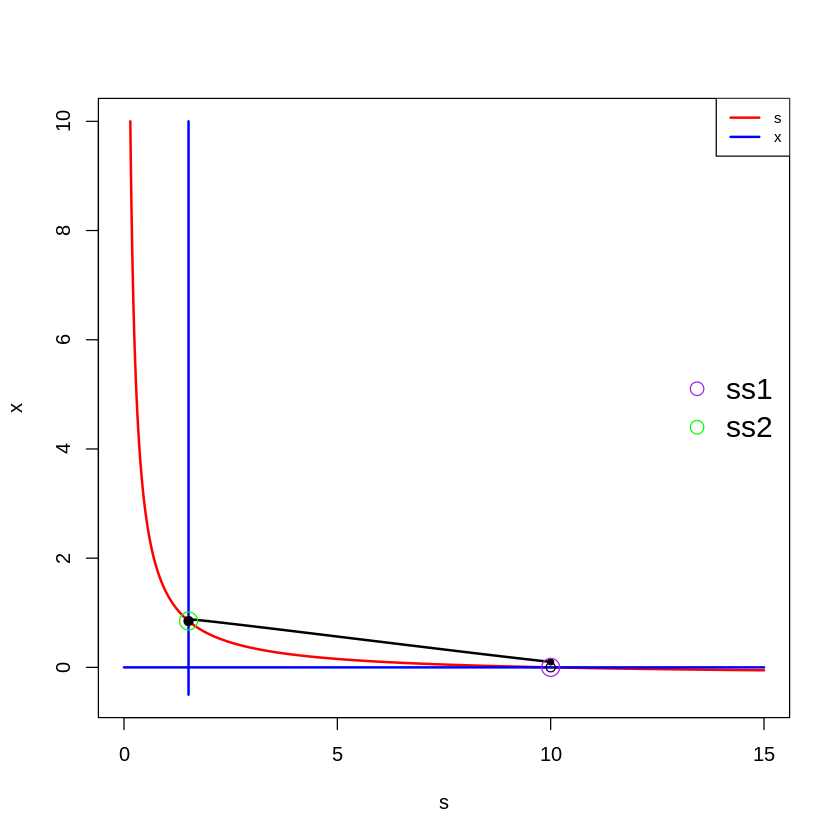

In [9]:
plane(xmin = 0, xmax = 15, ymin = -0.5, ymax = 10)
run(traject = T)

# para determinar la estabilidad de los puntos de equilibrio
newton(state = c(s = 10, x = 0), plot = T)
newton(state = c(s = 1.5, x = 0.85), plot = T)

# para distinguir entre los puntos de equilibrio 
ss_plot <- steady_state(p)
points(x = ss_plot$ss1[1], y = ss_plot$ss1[2], col = "purple", pch = 21, cex = 2)
points(x = ss_plot$ss2[1], y = ss_plot$ss2[2], col = "green", pch = 21, cex = 2)

legend("right", legend = c("ss1","ss2"), 
      col = c("purple", "green"), pch = 21, bty = "n", cex = 1.5)

De acuerdo con la la salida anterior. El punto de equilibrio $ss_1$ $(s = 10, x = 0)$ es inestable, mientras que el punto de equilibrio $ss_2$ $(s = 1.513, x = 0.849)$ es estable.  

## Efecto del parámetro D sobre el punto de equilibrio

        s         x 
1.5126018 0.8487398 
Stable point, eigenvalues:  -0.05564356 -0.01 
            s             x 
 1.000000e+01 -5.441808e-08 
Unstable point, eigenvalues:  0.0531579 -0.01 


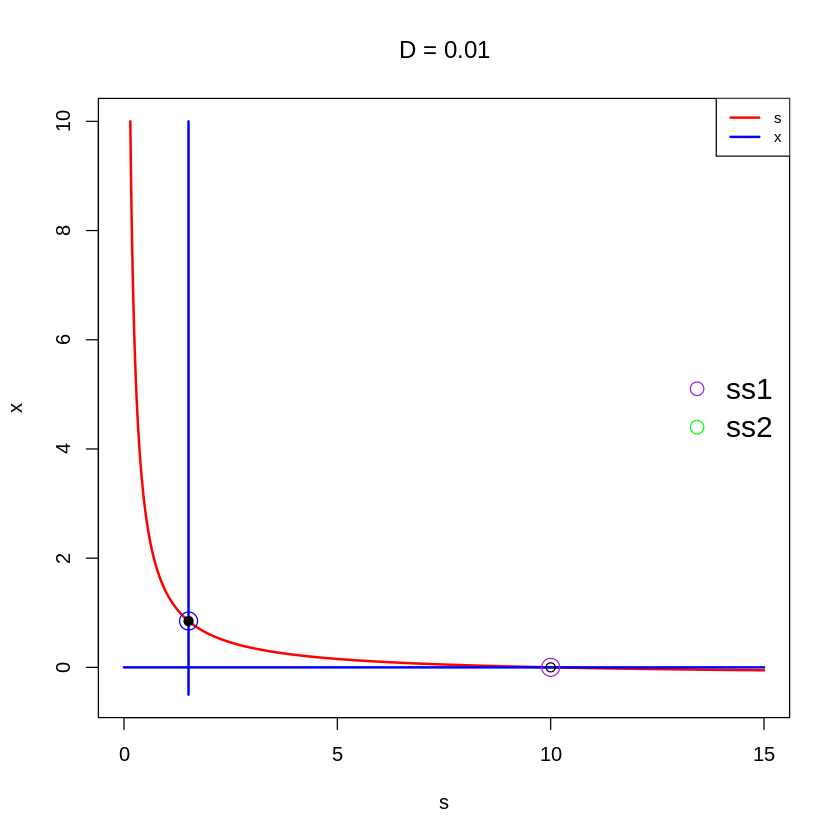

        s         x 
6.2068949 0.3793105 
Stable point, eigenvalues:  -0.04 -0.02362965 
 s  x 
10  0 
Unstable point, eigenvalues:  -0.04 0.02315789 


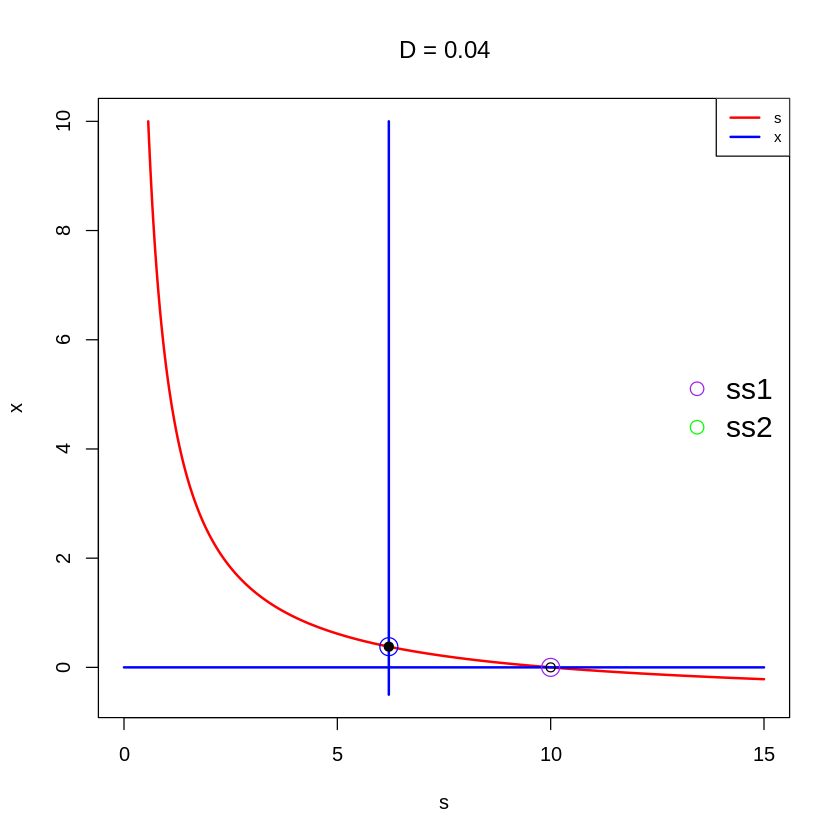

         s          x 
9.47368317 0.05263168 
Stable point, eigenvalues:  -0.06 -0.003166679 
            s             x 
 1.000000e+01 -1.010744e-07 
Unstable point, eigenvalues:  -0.06 0.003157907 


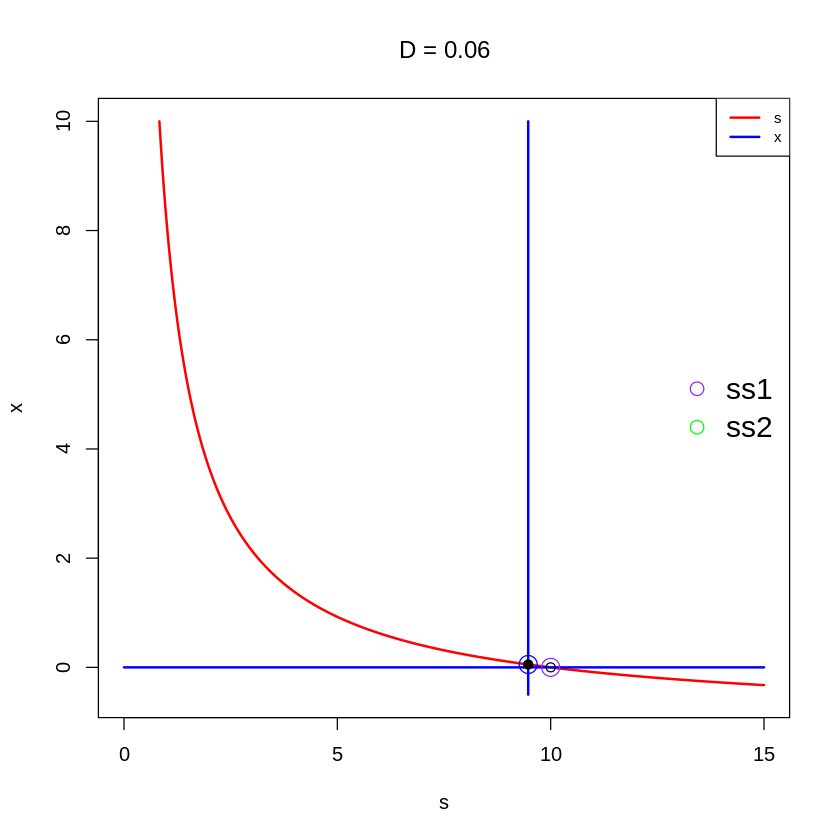

           s            x 
9.999999e+00 7.569379e-08 
Stable point, eigenvalues:  -0.08 -0.01684211 
         s          x 
12.8571458 -0.2857146 
Unstable point, eigenvalues:  -0.08 0.01659263 


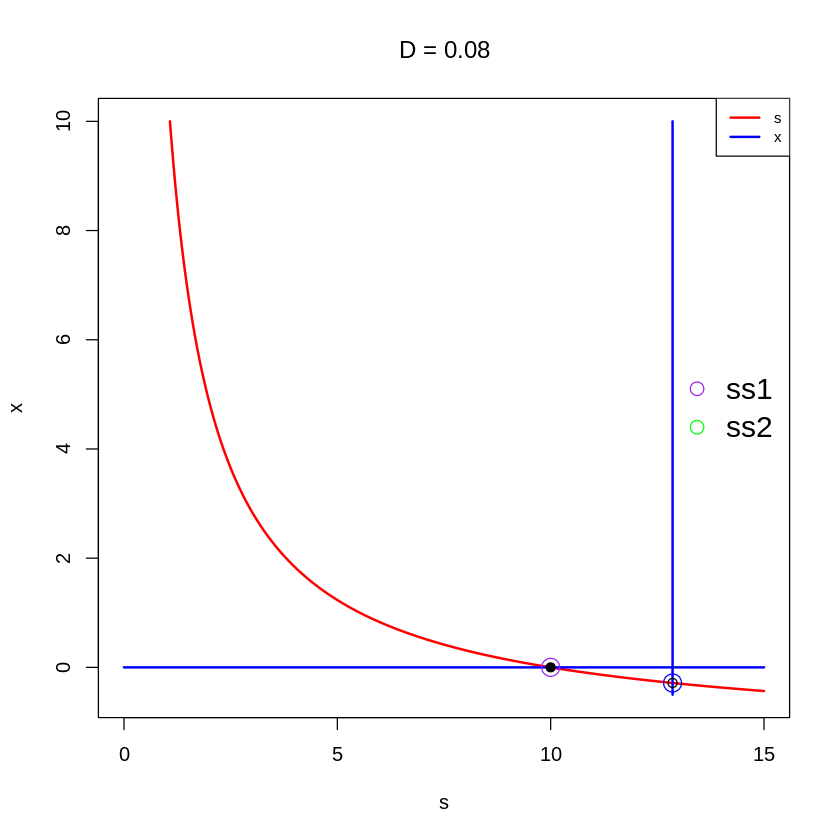

In [12]:
for (D in c(0.01,0.04,0.06,0.08)) {

  p["D"] <- D

  # para determinar estabilidad de los puntos de equilibrio
  plane(xmin = 0, xmax = 15, ymin = -0.5, ymax = 10, main = paste0("D = ", D))
  newton(state = c(s = 0, x = 1), plot = TRUE)
  newton(state = c(s = 15, x = - 0.5), plot = TRUE)

    # para distinguir entre los puntos de equilibrio 
  ss_plot <- steady_state(p)
  points(x = ss_plot$ss1[1], y = ss_plot$ss1[2], col = "purple", pch = 21, cex = 2)
  points(x = ss_plot$ss2[1], y = ss_plot$ss2[2], col = "blue", pch = 21, cex = 2)
  legend("right", legend = c("ss1","ss2"), 
        col = c("purple", "green"), pch = 21, bty = "n", cex = 1.5)
}

p["D"] <- 0.01 # Regresar D a su valor original

En la salida anterior vemos que al variar el valor del parámetro $D$ cambia el valor y la estabilidad de los puntos de equilibrio. Por ejemplo, al pasar de $D = 0.01$ a $D = 0.04$, el valor de $\bar{x}$ pasa de 0.8487 a 0.3779 (g/L), mientras que el valor de $\bar{s}$ pasa de 1.512 a 6.206 (g/L). Una primera observación de lo anterior es que el efecto de cambiar $D$ es mayor sobre $\bar{s}$ que sobre $\bar{x}$. Además, como la estabilidad de los puntos de equilibrio cambia, se espera observar una bifurcación.  

De los diagramas de plano de fase se puede observar que el valor del parámetro $D$ en el que ocurre la bifurcación es cuando 

$$\frac{k_sD}{\mu_{max} - D} = s_f$$

A partir de aquí un aumento del valor de $D$ ocasiona que el punto de equilibrio $ss_1$ $(s = s_f, x = 0)$ se vuelva estable y el punto de equilibrio $ss_2$ $(s = k_sD/(\mu_{max} - D), x = Y_{sx}(s_f-s))$ se vuelva inestable 

Por lo anterior, el punto de bifurcaión del parámetro $D$ ocurre en 

$$D_{bif} = \frac{\mu_{max} s_f }{k_s + s_f}$$

Para comprobar lo anterior establecemos una función que calcule el valor de $D_{bif}$ y graficamos este valor junto con el diagrama de bifurcación 

In [14]:
# función para calcular D*
D_bif <- function(p) {
  with(as.list(p), {

    D = mu_max*sf/(ks + sf)

    return(D)
  })
}

## Diagrama de bifurcación 

        s         x 
1.5126050 0.8487395 
Stable point, eigenvalues:  -0.05564352 -0.01 
Starting at D = 0.01 with:
        s         x 
1.5126050 0.8487395 
         s          x 
12.8571569 -0.2857157 
Unstable point, eigenvalues:  -0.08 0.01659275 
Starting at D = 0.08 with:
         s          x 
12.8571569 -0.2857157 


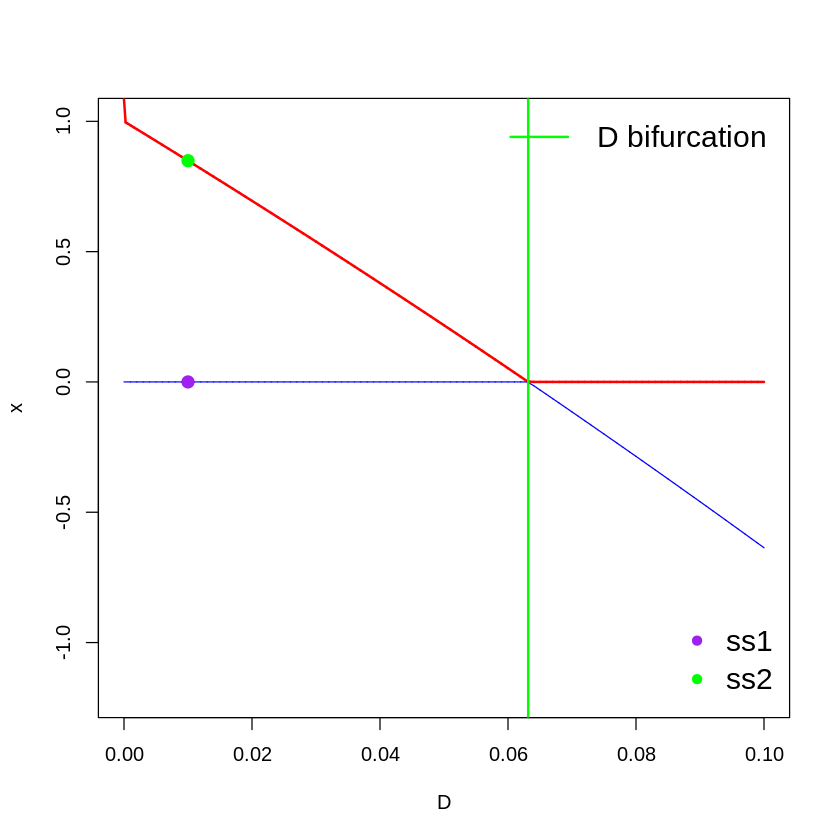

In [15]:
ss1 <- newton(state = c(s = 1.5, x = 0.84))
continue(state = ss1, parms = p, odes = model, x = "D", 
         step = 0.01, xmin = 0.0, xmax = 0.1, y = "x", ymin = -1.2, ymax = 1)
p["D"] <- 0.08
ss2 <- newton(state = c(s = 13, x = -0.3))
continue(state = ss2, parms = p, odes = model, x = "D", 
         step = 0.01, xmin = 0.0, xmax = 0.1, y = "x", ymin = -1.2, ymax = 1, add = TRUE)
abline(v = D_bif(p))
p["D"] <- 0.01

# para graficar Dcrit, Dbif y los puntos de equilibrio en D = 0.01
ss_plot <- steady_state(p)
abline(v = D_bif(p), col = "green", lwd = 2)
points(x = p["D"], y = ss_plot$ss1[2], col = "purple", pch = 20, cex = 2)
points(x = p["D"], y = ss_plot$ss2[2], col = "green", pch = 20, cex = 2)
legend("topright", legend = c("D bifurcation"), 
        col = "green", lty = 1, bty = "n", lwd = 2, cex = 1.5)
legend("bottomright", legend = c("ss1","ss2"), 
        col = c("purple", "green"), pch = 20, bty = "n", cex = 1.5)

        s         x 
1.5126050 0.8487395 
Stable point, eigenvalues:  -0.05564352 -0.01 
Starting at D = 0.01 with:
        s         x 
1.5126050 0.8487395 
         s          x 
12.8571569 -0.2857157 
Unstable point, eigenvalues:  -0.08 0.01659275 
Starting at D = 0.08 with:
         s          x 
12.8571569 -0.2857157 


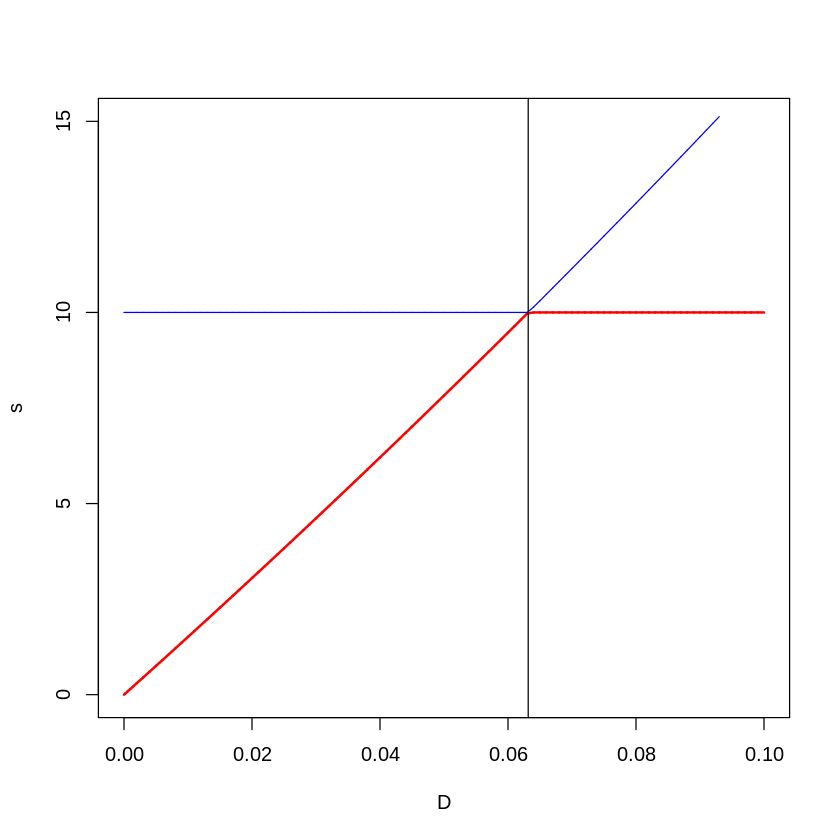

In [100]:
ss1 <- newton(state = c(s = 1.5, x = 0.84))
continue(state = ss1, parms = p, odes = model, x = "D", 
         step = 0.01, xmin = 0.0, xmax = 0.1, y = "s", ymin = 0, ymax = 15)
p["D"] <- 0.08
ss2 <- newton(state = c(s = 13, x = -0.3))
continue(state = ss2, parms = p, odes = model, x = "D", 
         step = 0.01, xmin = 0.0, xmax = 0.1, y = "s", ymin = 0, ymax = 15, add = TRUE)
abline(v = D_bif(p))
p["D"] <- 0.01

Vemos que el valor que de $D^{*}$ que obtuvimos del plano de fase concuerda con lo obtenido al graficar el diagrama de bifurcación. Como se observa en el diagrama, los puntos de equilibrio $ss_1$ y $ss_2$ no se generan ni se eliminan al pasar por el punto de bifurcación, solamente cambia su estabilidad. Cuando esto ocurre a la bifurcación se le denomina bifurcación transcrítica. 

### Restricciones en el punto de equilibrio 

Vemos que el punto de equilibrio 

$$ss_2: \hspace{1cm} \bar{s} = \frac{Dk_s}{\mu_{max} - D}, \hspace{0.25cm} \bar{x} = Y_{xs}(s_f - \bar{s}), \hspace{0.25cm} \bar{p} = Y_{px}\bar{x}$$

requiere que el valor de $D$ sea menor que $\mu_{max}$ para tener un valor positivo de sustrato en el equilibrio. Para entender esto podemos graficar la tasa de crecimiento y la tasa de dilución como función de la concentración de sustrato.

In [84]:
# función para graficar tasas de crecimiento y dilución 
rates <- function(p, Dil) {
  with(as.list(p), {

    s <- seq(0,1000,len = 1000)
    # tasa de crecimiento 
    mu = mu_max*s/(ks + s)

    # tasa de dilución 
    D = rep(Dil, length(s))

    out = data.frame(s = s, mu = mu, D = D)

    return(out)

  })
}

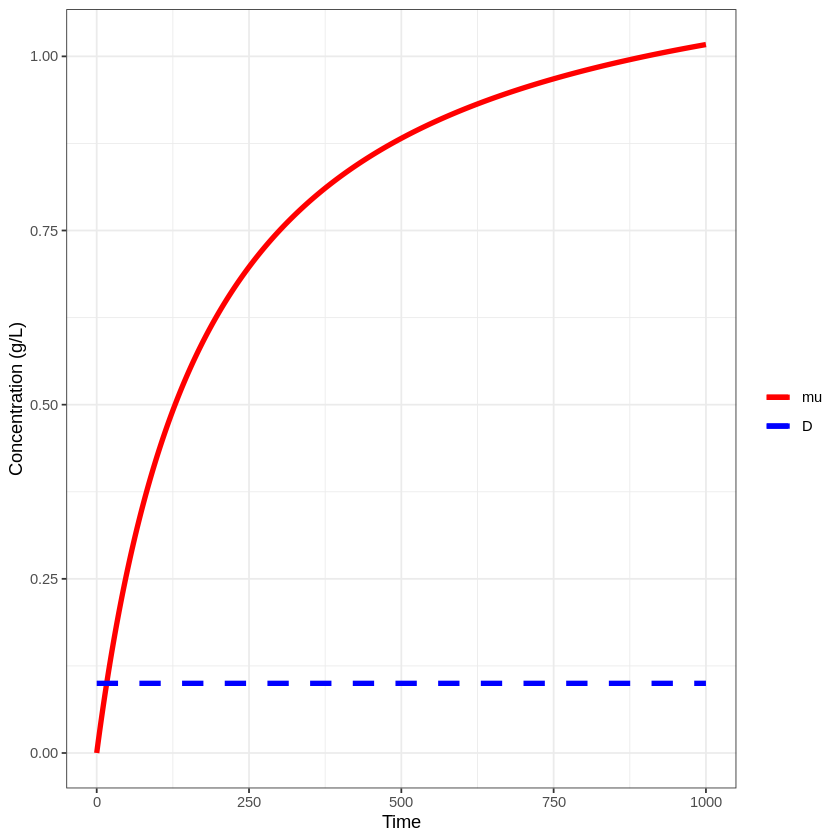

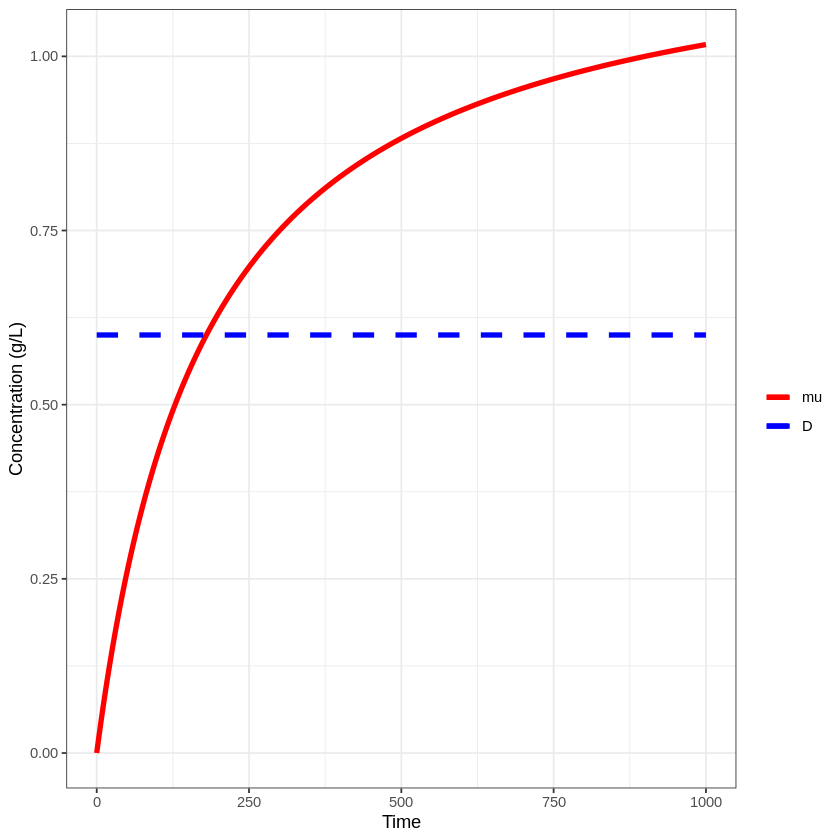

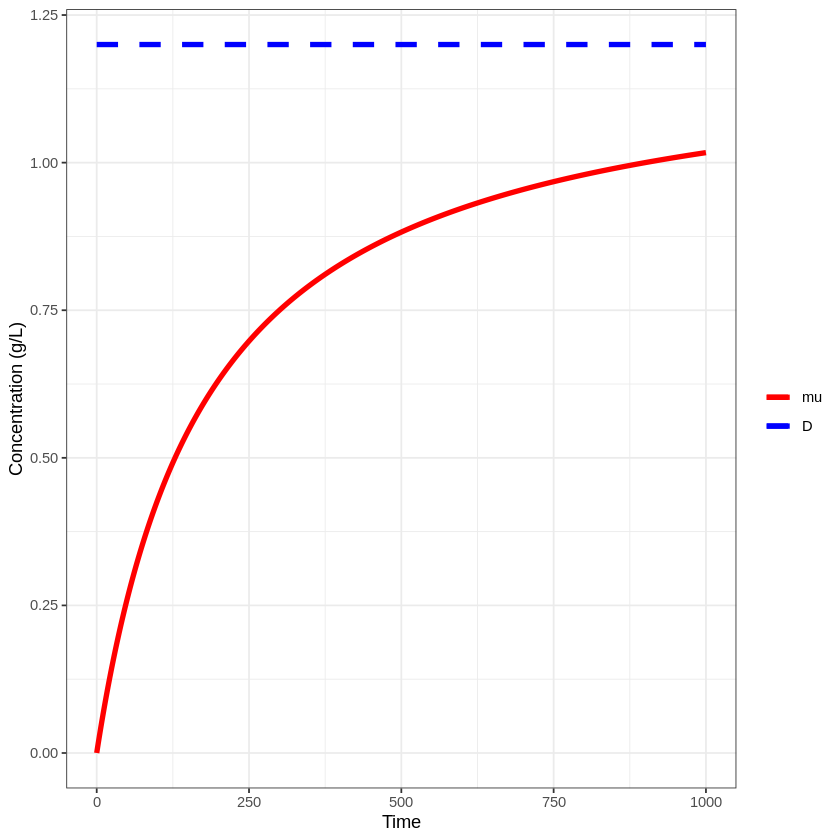

In [85]:
for (Dil in c(0.1, 0.6, 1.2)) {
  out <- rates(p, Dil)
  # graficar tasas 
  print(
    ggplot(out,aes(s)) +
    geom_line(aes(y = mu, color = "mu"), lwd = 1.5) +
    geom_line(aes(y = D, color = "D"), lwd = 1.5, lty = 2) + 
    scale_color_manual("", breaks = c("mu","D"), values = c("red", "blue")) +
    xlab("Time") +
    ylab("Concentration (g/L)") +
    theme(title = paste0("D = ", D)) +
    theme_bw()
  )
}

Para que exista un equilibrion en la concentración de biomasa, es decir $dx/dt = 0$, es necesarion que la tasa de crecimiento iguale a la tasa de dilución, pero como se puede observar en la salida anterior, si la tasa de dilución es demasiado grande, no importa cuando aumente $s$, las tasas no serán iguales. 

## Linealización

El siguiente analisis se puede obtener usando la función `newton()`, sin embargo, se considera importante observar la manera en la que se calcula la estabilidad de los puntos de equilibrio a partir de la linealización del sistema de EDO.

Las derivadas parciales en la matriz Jacobiana se pueden obtener mediante la librería `numpy` de Python. 

https://github.com/JuanM-GG/sistemas-dinamicos-Python/blob/main/puntos_de_equilibrio_monod.ipynb

In [86]:
# función que calcula la matriz Jacobiana en el punto de equilibrio 
my_jacobi <- function(ss,p) {
  with(as.list(c(ss,p)), {

    dfdx = mu_max*s/(ks + s) - D
    dfds = mu_max*ks*x/(ks + s)**2
    dgdx = -(1/Yxs)*mu_max*s/(ks + s)
    dgds = -D - (1/Yxs)*mu_max*ks*x/(ks + s)**2

    A = matrix(c(dfdx,dfds,dgdx,dgds), nrow = 2, byrow = T)

    trace = dfdx + dgds

    det = dfdx*dgds - dgdx*dfds

    lamda1 = (trace - (trace**2 - 4*det)^{1/2})/2
    lamda2 = (trace + (trace**2 - 4*det)^{1/2})/2

    out = list(A = A, eigenvals = c(lamda1 = round(lamda1, 3), lamda2 = round(lamda2, 3)))

    return(out)

  })
}

Recordemos el valor de los parámetros 

In [87]:
print(p)

mu_max     ks    Yxs      D     sf 
  1.20 180.00   0.10   0.01  10.00 


In [16]:
# obtener puntos de equilibrio 
ss1 <- steady_state(p)$ss1
ss2 <- steady_state(p)$ss2

cat("ss1: \n")
cat("s = ",ss1[1],"x = ",ss1[2],"\n")
cat("ss2: \n")
cat("s = ",ss2[1],"x = ",ss2[2],"\n")

ss1: 
s =  10 x =  0 
ss2: 
s =  1.513 x =  0.849 


In [89]:
# evaluar matriz Jacobiana en punto de equilibrio ss1 (s = sf, x = 0)
J1 <- my_jacobi(ss1, p)
print(J1)

$A
            [,1]  [,2]
[1,]  0.05315789  0.00
[2,] -0.63157895 -0.01

$eigenvals
lamda1 lamda2 
-0.010  0.053 



Dado que el signo de los eigenvalores es opuesto, el punto de equilibrio $ss_1$  es inestable, en particular, es un punto silla

In [90]:
# evaluar matriz Jacobiana en punto de equilibrio (s* = k*D/(mu-D), x* = y*(sf-s*))
J2 <- my_jacobi(ss2, p)
print(J2)

$A
              [,1]         [,2]
[1,]  2.589346e-06  0.005566035
[2,] -1.000259e-01 -0.065660355

$eigenvals
lamda1 lamda2 
-0.056 -0.010 



Dado que ambos eigenvalores tienen signo negativo, el punto de equilibrio $ss_2$ es estable. En este caso, porque los eigenvalores son números reales, sabemos que el ´punto de equilibrio es un nodo estable.

Estos resultados son los mismos que el obtenidos con la fución `newton()`

#	Análisis dinámico (integración numérica)

A continuación realizamos la integración numérica para evaluar el comportamiento dinámico del modelo

Aquí es importante recordad el valor de los parámetros que hemos establecido 

In [17]:
print(p)

mu_max     ks    Yxs      D     sf 
  1.20 180.00   0.10   0.01  10.00 


In [91]:
# tiempo de simulación 
times <- seq(0,500,len=1000)

In [92]:
# resolver EDOs
out <- ode(func = model, y = s, times = times, parms = p, method = "rk4")

In [93]:
# guardar resultados
out <- as.data.frame(out)
# añadir puntos de equilibrio 
out$s_ss <- rep(ss2[1], length(times))
out$x_ss <- rep(ss2[2], length(times))

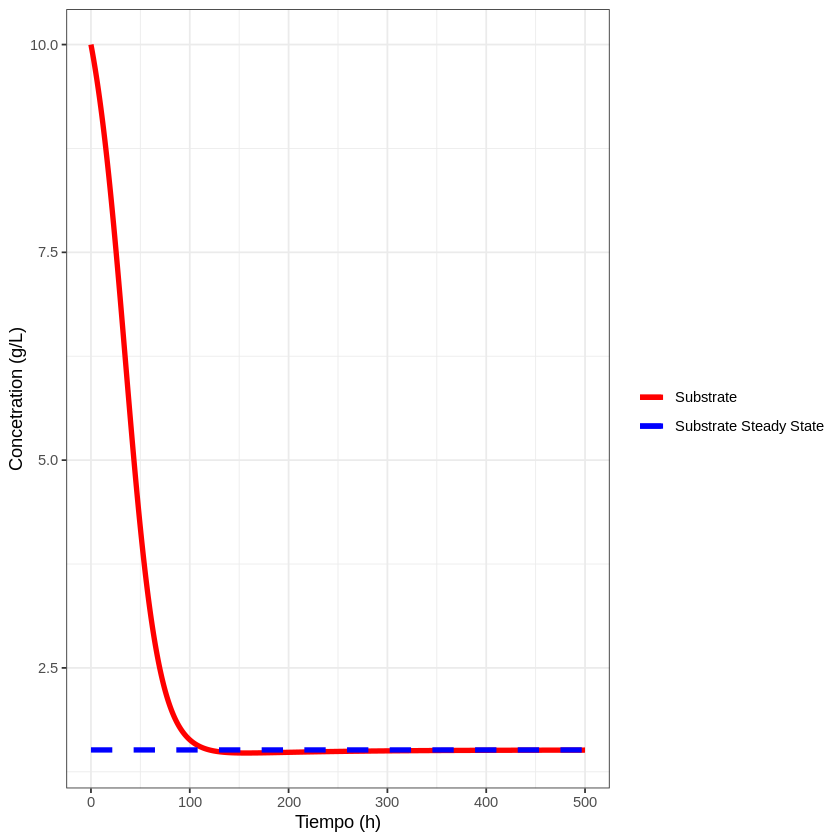

In [94]:
# mostrar resultados de sustrato
ggplot(out, aes(time)) +
  geom_line(aes(y = s, color = "Substrate"), lwd = 1.5) +
  geom_line(aes(y = s_ss, color = "Substrate Steady State"), lwd = 1.5, lty = 2) +
  xlab("Tiempo (h)") +
  ylab("Concetration (g/L)") + 
  scale_color_manual("", breaks = c("Substrate","Substrate Steady State"), values = c("red", "blue")) +
  theme_bw()

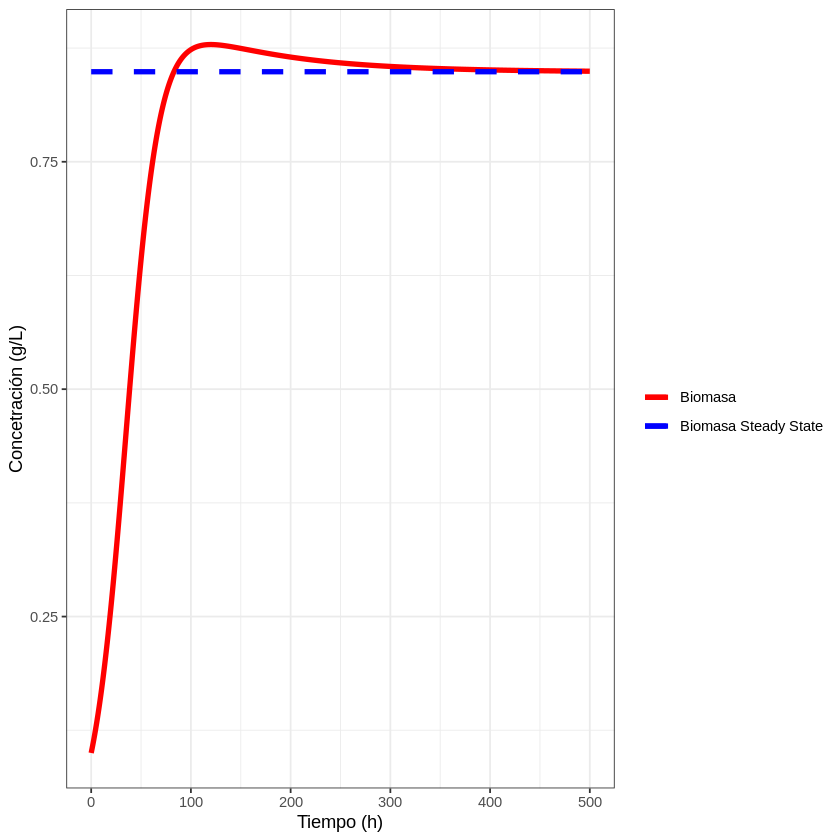

In [95]:
# mostrar resultados de biomasa 
ggplot(out, aes(time)) +
  geom_line(aes(y=x, color = "Biomasa"), lwd = 1.5, lty = 1) +
  geom_line(aes(y=x_ss, color = "Biomasa Steady State"), lwd = 1.5, lty = 2) +
  xlab("Tiempo (h)") +
  ylab("Concetración (g/L)") + 
  scale_color_manual("", breaks = c("Biomasa","Biomasa Steady State"), values = c("red", "blue")) +
  theme_bw()

Vemos que el sistema tiende al punto de equilibrio $ss_2$, lo cual concuerda con el análisis de estabilidad que hemos realizado. 

Podemos usar la función `plane()` para evaluar el comportamiento bajo diferentes condiciones iniciales 

 s  x 
10  0 
Unstable point, eigenvalues:  0.05315789 -0.01 


s  x 
10  0

        s         x 
1.5125855 0.8487414 
Stable point, eigenvalues:  -0.05564379 -0.01 


s         x 
1.5125855 0.8487414

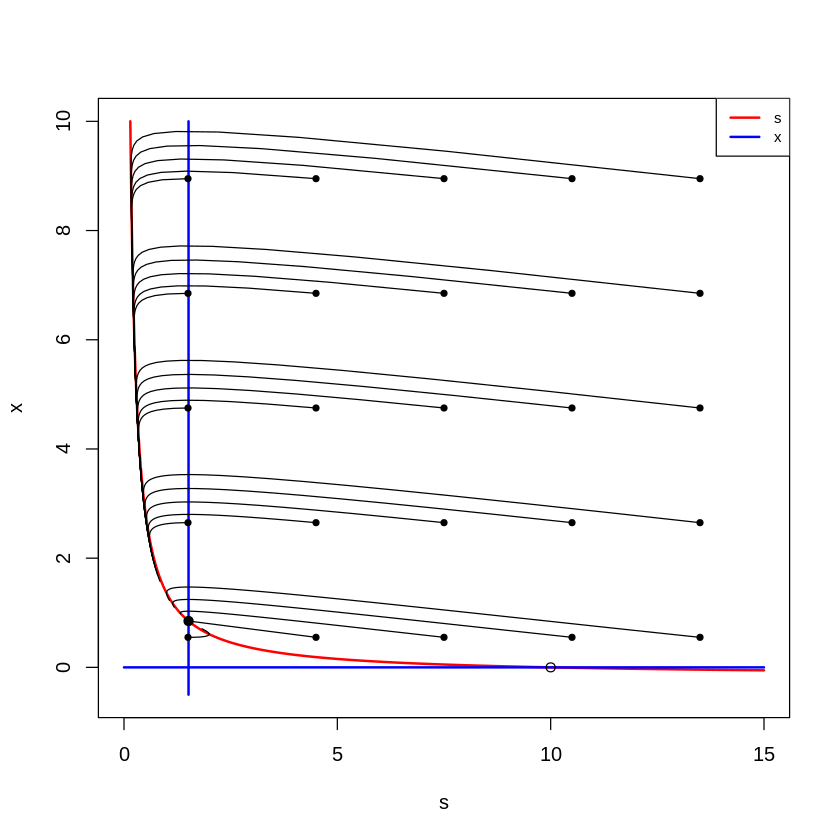

In [96]:
plane(xmin = 0, xmax = 15, ymin = -0.5, ymax = 10, portrait = T)
newton(state = c(s = 10, x = 0), plot = T)
newton(state = c(s = 1.5, x = 0.85), plot = T)

Vemos que para todas las condiciones iniciales que se evaluaron, el sistema siempre tiene al punto de equilibrio $ss_2$

# Optimización paramétrica

En esta sección el modelo que se emplea para realizar la optimización describe un tipo de operación tipo lote. Lo cuál implica reescribir el modelo anterior haciendo $D = 0$. Las variables experimentales de las que se tienen mediciones son biomasa, $x$, sustrato, $s$ y producto, $p$. La fermentacións se realiza durante un intervalo de tiempo de 60 horas, tomando mediciones cada 4 horas. El interés de realizar la optimización paramétrica es usar los parámetros obtenidos para caracterizar la fermentación y realizar un análisis estadístico. Del balance de masa se tiene

### Balance de materia para biomasa

$$acumulación\ de\ biomasa= \ generación$$


$$
\frac{d(xV)}{dt} = V r_x 
$$

Dado que el volumen es constante

<a id='equation-la-se2'></a>
$$
\frac{dx}{dt} = r_x \tag{9}
$$


### Balance de materia para sustrato

$$acumulación\ de\ sustrato=\ - consumo$$

$$
\frac{d(sV)}{dt} =  - V r_s 
$$

Considerado 

$$r_s = \frac{1}{Y_{xs}} r_x$$ \\

Se tiene
<a id='equation-la-se2'></a>
$$
\frac{ds}{dt} =  - \frac{1}{Y_{xs}} r_x  \tag{10}
$$

### Balance de materia para producto

$$acumulación\ de\ producto=\ generación$$

$$
\frac{d(pV)}{dt} =  V r_p 
$$

Considerado 

$$r_p = Y_{px} r_x$$ \\

Se tiene
<a id='equation-la-se2'></a>
$$
\frac{dp}{dt} =  Y_{px} r_x  \tag{11}
$$

Siendo 

$$r_x = \mu_{max} \left( \frac{s}{k_s + s} \right) x$$

## Cargar los datos experimentales 

In [97]:
# cargar los datos 
data <- read.xlsx("IT.xlsx", sheetIndex = 1)
tail(data)

ERROR: ignored

In [ ]:
# revisar los datos 
str(data)

### Comparar modelo con datos experimentales 

In [ ]:
# establecer modelo para reactor tipo lote 
model <- function(time, state, parms) {
  with(as.list(c(state, parms)), {

    # tasas de crecimiento de biomasa
    mu = mu_max*(s/(ks + s))

    # velocidad de crecimiento de biomasa
    rx = mu*x

    # velocidad de consumo de sustrato
    rs = (1/Yxs)*rx
    
    # velocidad de generación de producto
    rp = Ypx*rx

    # balances de materia para el sustrato
    dsdt <- - rs

    # balance de materia para la biomasa
    dxdt <- rx

    # balance de materia para el producto 
    dpdt <-  rp

    return(list(c(dsdt, dxdt, dpdt)))
  })
}

In [ ]:
# parámetros del modelo
p <- c(mu_max = 1.2, ks = 280, Yxs = 0.2, Ypx = 4)

In [ ]:
# condiciones iniciales
s <- c(s = data$s[1], x = data$x[1], p = data$p[1])

In [ ]:
# tiempo de integración 
times <- seq(0,60,4)

In [ ]:
out <- ode(y=s, times = times, parms = p, func = model, method = "rk4")
out <- as.data.frame(out)

In [ ]:
# comparamos modelo y datos experimentales (biomasa)
ggplot(data, aes(x=time)) +
  geom_point(aes(y = x, color = "x_exp"), size = 2) +
  geom_line(data = out, aes(y = x, color = "x_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("x_exp", "x_pred"), values = c("red", "blue")) +
  xlab("Time (h)") +
  ylab("Concentration (g/L)") + 
  theme_bw()

In [ ]:
# comparamos modelo y datos experimentales (sustrato)
ggplot(data, aes(x=time)) +
  geom_point(aes(y = s, color = "s_exp"), size = 2) +
  geom_line(data = out, aes(y = s, color = "s_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("s_exp", "s_pred"), values = c("red", "blue")) +
  xlab("Time (h)") +
  ylab("Concentration (g/L)") + 
  theme_bw()

In [ ]:
# comparamos modelo y datos experimentales (producto)
ggplot(data, aes(x=time)) +
  geom_point(aes(y = p, color = "p_exp"), size = 2) +
  geom_line(data = out, aes(y = p, color = "p_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("p_exp", "p_pred"), values = c("red", "blue")) +
  xlab("Time (h)") +
  ylab("Concentration (g/L)") + 
  theme_bw()

## Establecer función objetivo 

En la optimización paramétrica lo más común es definir la función objetivo como la función de costo:

$$F(p) = \sum_{i = 1}^{n} \left( \hat{x}_i - x_{exp,i} \right)^{2}$$

Donde $n$ es el número de observaciones en nuestros datos, $\hat{x}_i$ representa la i-ésima predicción hecha con el modelo y $x_{exp,i}$ la i-ésima observación expermiental. 

In [ ]:
cost <- function(x, data) {

  names(x) <- names(p)
  out <- ode(y = c(s = data$s[1], x = data$x[1], p = data$p[1]), 
            times = times, 
            parms = x, 
            func = model, 
            method = "rk4")

  f <- -modCost(model = out, obs = data)$model
  return(f)
}

Esta función recibe un vector de parámetros, le asigna los nombres del vector p, y utiliza los valores contenidos en el vector para simular el modelo y comparar con los datos expermientales. El valor negativo es debido a que la función `ga()` que realiza la optimización busca maximizar la función ` cost()`. 

In [ ]:
cost(p, data)

### Algoritmo Genético 

In [ ]:
# realizar la optimización paramétrica
set.seed(123)
GA1 <- ga(type = "real-valued",
      fitness = cost, 
      data = data,
      lower = rep(0, length(p)),
      upper = 2*p,
      popSize = 50,
      pcrossover = 0.8,
      pmutation = 0.1,
      elitism = 2,
      maxiter = 100,
      maxFitness = 0)

Resultados obtenidos con el algoritmo genético 

In [ ]:
print(GA1@solution)
cat("error: ", GA1@fitnessValue)

### Comparar simulación con parámetros óptimos y datos experimentales

In [ ]:
# parámetros óptimos para la cmparación 
p_opt <- GA1@solution[1,]

In [ ]:
# condiciones iniciales
s <- c(s = data$s[1], x = data$x[1], p = data$p[1])

In [ ]:
# tiempo de integración 
times <- seq(0,60,4)

In [ ]:
out <- ode(y=s, times = times, parms = p_opt, func = model, method = "rk4")
out <- as.data.frame(out)

In [ ]:
# comparamos modelo y datos experimentales (biomasa)
ggplot(data, aes(x=time)) +
  geom_point(aes(y = x, color = "x_exp"), size = 2) +
  geom_line(data = out, aes(y = x, color = "x_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("x_exp", "x_pred"), values = c("red", "blue")) +
  xlab("Time (h)") +
  ylab("Concentration (g/L)") + 
  theme_bw()

In [ ]:
# comparamos modelo y datos experimentales (sustrato)
ggplot(data, aes(x=time)) +
  geom_point(aes(y = s, color = "s_exp"), size = 2) +
  geom_line(data = out, aes(y = s, color = "s_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("s_exp", "s_pred"), values = c("red", "blue")) +
  xlab("Time (h)") +
  ylab("Concentration (g/L)") + 
  theme_bw()

In [ ]:
# comparamos modelo y datos experimentales (producto)
ggplot(data, aes(x=time)) +
  geom_point(aes(y = p, color = "p_exp"), size = 2) +
  geom_line(data = out, aes(y = p, color = "p_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("p_exp", "p_pred"), values = c("red", "blue")) +
  xlab("Time (h)") +
  ylab("Concentration (g/L)") + 
  theme_bw()

Tabla2. Parámetros encontrados al hacer la optimización

| Parámetro | Valor |
| :------- | :----: | 
| $\mu_{max}$ | $1.9494 h^{-1}$  |
| $k_s$  | $364.8109$ g/L | 
| $Y_{xs}$ | $0.11315$ |
| $Y_{px}$ | $6.5765$ |

# Optimzación de la producción de biomasa 

Ahora podríamos preguntarnos sobre cuál es el valor del parámetro $D$ que nos permite generar una mayor cantidad de biomasa. Consideremos, por ejemplo, una valor de $D$ muy bajo. Como vimos en el diagrama de bifurcación, una valor bajo da lugar a un valor de concentración de biomasa en el equilibrio, $\bar{x}$, alto, sin embargo, al ser el flujo en la salida del biorreactor demasiado bajo, el flujo de biomasa en la salida también lo será. Por otro lado, si el valor de $D$ es muy alto, tendremos una mayor flujo de biomasa en la salida pero de acuerdo con el diagrama de bifurcación, el valor de la concentración de biomasa será muy bajo. 

Para resolver este problema de optimización empezamos por definir la función que nos interesa optimizar, en este caso, esta función es la cantidad de biomasa que se obtiene del biorreactor

$$G(D) = D \bar{x}$$

Donde $\bar{x}$ es la concetración de biomasa en el equilibrio. 

Considerando 

$$\bar{x} = Y_{xs} (s_f - \bar{s}) \hspace{1cm} y \hspace{1cm} \bar{s} = \frac{D k_s}{\mu_{max} - D}$$

Tenemos 

$$G(D) = D Y_{xs} (s_f - \frac{D k_s}{\mu_{max} - D})$$

Si tomamos en cuenta el hecho de que $\mu_{max} >> D$ entonces 

$$G(D) \approx D Y_{xs} (s_f - \frac{D k_s}{\mu_{max}})$$

In [137]:
# establecer función objetivo 
gain1 <- function(Dr, p) {
  with(as.list(p), {

    G = Dr*Yxs*(sf - Dr*ks/(mu_max))

    return(G)

  })
}

In [138]:
# valores de D a evaluar
D <- seq(0,0.08,len=100)

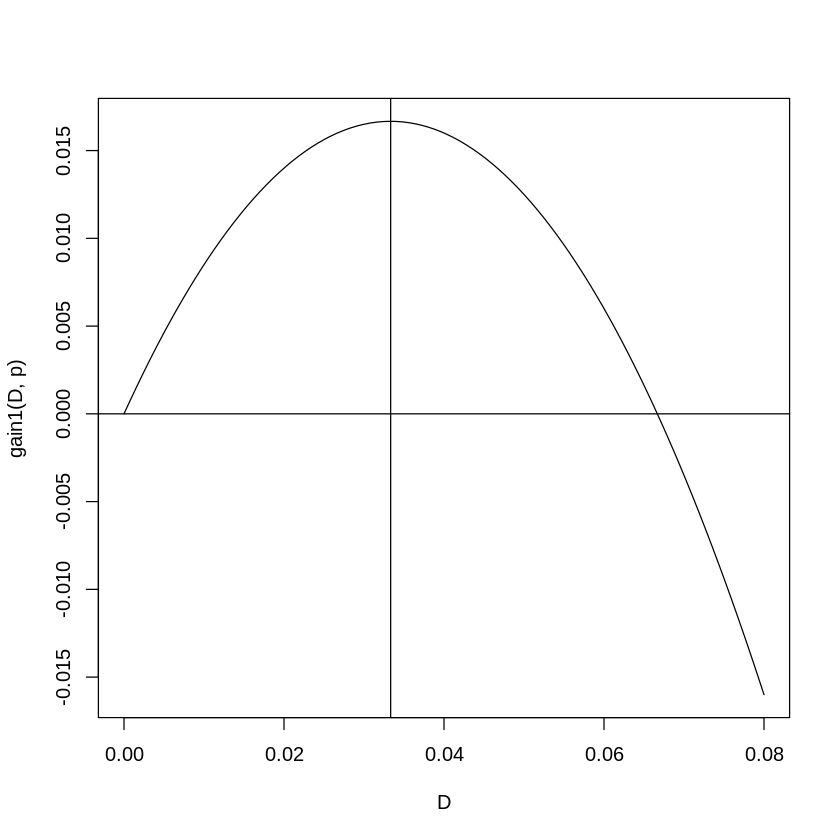

In [139]:
# mostrar resultados 
plot(D, gain1(D,p), type = "l")
with(as.list(p), {
  abline(h = 0, v = mu_max*sf/(2*ks))
})

Es fácil mostrar que el valor de $D$ que permite obtener la mayor cantidad de biomasa, en condiciones estacionarias, es

$$D = \frac{\mu_{max} s_f}{2k_s}$$

Aun así, mostramos como encontrar este valor usando la función `optimise()`

In [140]:
gain2 <- function(Dr) {
        
        G = gain1(p = p, Dr = Dr)
        
        return(-G)
}

Esta función encuentra el mínimo de una función, por esta razón se multiplica por menos el valor de biomasa que se obtiene

In [141]:
sol <- optimise(f = gain2, lower = 0,upper = 0.08)

cat("D_opt:", sol$minimum, "h^-1 \n")
cat("mx_max: ", - sol$objective, "g")

D_opt: 0.03333333 h^-1 
mx_max:  0.01666667 g

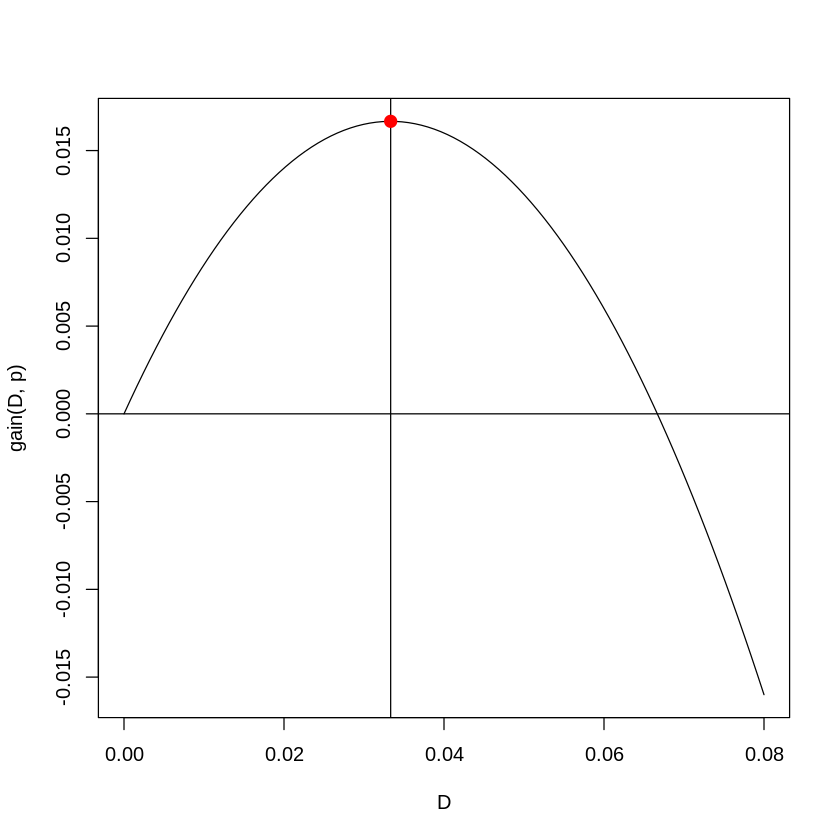

In [142]:
# mostrar resultados 
plot(D, gain(D,p), type = "l")
with(as.list(p), {
  abline(h = 0, v = mu_max*sf/(2*ks))
})
points(sol$minimum, -sol$objective, col = "red", pch = 20, cex = 2)

# Conclusiones 

* En modelo de Monod  presenta dos puntos de equilibrio cuya estabilidad y valores dependen del parámetro $D$. 

* El valor de la bifurcación con respecto al parámetro D ocurre cuando $D = \mu_{max}s_f/(k_s + s_f)$. Dado que ninguno de los puntos de equilibrio se crea o se destruye durante la bifurcación, solo cambian su estabilidad, se considera que ocurre una bifurcación transcrítica. 

* Para que se presente el punto de equilibrio no trivial, $ss_2$, es necesario considerar cierta restricción entre los parámetros, en específico se debe cumplir

$$D < \mu_{max}$$

* Mediante el uso de algoritmos genéticos fue posible encontrar el valor de los parámetros que describien mejor los datos experimentales Tabla.2. 